# Objectifs de ce notebook

Ce notebook est destiné à explorer la pertinence des features "non localisés" utilisés pour la classification des défauts dans les images thermographiques de modules photovoltaïques.

Pour rappel, les images thermographiques dont nous disposons sont des images en 256 niveaux de gris (la représentation en couleurs de ces images résulte seulement de l'application d'une palette RGB de type 'inferno' permettant une meilleure différentiation des niveaux de température pour l'oeil humain). Nous ne maîtrisons pas et n'avons aucune information sur la chaîne de pré-traitement ayant permis la conversion des valeurs de température mesurées par les caméras thermiques en niveaux de gris.

Les features "non localisés" comprennent :

  - les indicateurs statistiques classiques, du type moyenne, médiane, min, max, etc. calculés sur l'ensemble des pixels de l'image
  - les quantiles p5, p10, p15... à p95
  - l'histogramme de l'image, pour chaque niveau de 0 à 255
  - les caractéristiques extraites de la matrice GLCM (Gray-Level Co-occurence Matrix) calculée sur l'image
  - les indicateurs statistiques calculés sur la carte d'entropie, qui caractérise la complexité locale de l'image
  - la densité de contours, obtenus à l'aide d'un filtre de Canny
  - des caractéristiques statistiques liées aux "hot spots" repérés dans les images à l'aide d'un seuillage OTSU

La raison pour laquelle il a été décidé de se focaliser sur des features "non localisés" est une raison "métier", liée à la physique des défaillances des modules photovoltaïques : la plupart des classes de défaut à notre disposition sont liées à des défaillances qui peuvent se produire à n'importe quel endroit d'un module photovoltaïque. Les seules exceptions (dans notre jeu de données) sont "junction box", que l'on retrouve nécessairement au niveau de la position des boîtes de jonction placées en face arrière, et "bottom dirt", dû à l'accumulation de salissures en bas de module par l'effet de la gravité combiné à d'éventuelles précipitations.

# Configuration

En phase de développement, il peut être utile de faire en sorte que tout changement dans les modules importés soit immédiatement pris en compte dans le notebook.

In [1]:
%load_ext autoreload
%autoreload 2

Ci-dessous on définit le fichier permettant de charger notre jeu de données.

In [2]:
PVF10_CSVFILE = "../data/processed/structure_pvf_10.csv"

Ensuite on définit quelques variables globales permettant de choisir ce qu'on souhaite exécuter ou non dans le notebook.

In [69]:
# MLflow
ACTIVATE_MLFLOW = True
MLFLOW_LOG_ALL_RUNS = False
# MLFLOW_URI = "http://truenas:35000"
# MLFLOW_URI = "http://mlflow.philippemarechal.org:35000"
MLFLOW_URI = "http://localhost:8080"

# Pré-chargement des modules
PRELOAD_MODULES = True

# Chargement et préparation du dataset

## Chargement du fichier csv généré à l'étape d'exploration

In [4]:
import pandas as pd

df_pvf10 = pd.read_csv(PVF10_CSVFILE)

display(df_pvf10.head())

,Chemin,Format,Train_Test,Classe,Nom,Type,Largeur,Hauteur,Canaux,Doute_Carre
0,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228122654_0466_T_000001,.png,60,110,3,False
1,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228122803_0500_T_000001,.png,60,110,3,False
2,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228123425_0666_T_000002,.png,60,110,3,False
3,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228124402_0129_T_000002,.png,60,110,3,False
4,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228124624_0220_T_000001,.png,60,110,3,False


On constate que les chemins stockés dans le fichier .csv contiennent un mélange de séparateurs '/' et '\\'.

On décide d'harmoniser le tout en utilisant '/'.

In [5]:
df_pvf10["Chemin"] = df_pvf10["Chemin"].str.replace("\\", "/")

display(df_pvf10)

,Chemin,Format,Train_Test,Classe,Nom,Type,Largeur,Hauteur,Canaux,Doute_Carre
0,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228122654_0466_T_000001,.png,60,110,3,False
1,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228122803_0500_T_000001,.png,60,110,3,False
2,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228123425_0666_T_000002,.png,60,110,3,False
3,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228124402_0129_T_000002,.png,60,110,3,False
4,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228124624_0220_T_000001,.png,60,110,3,False
...,...,...,...,...,...,...,...,...,...,...
16711,../data/raw/PVF-10/PVF_10_Ori/train/10healthy ...,Ori,train,healthy panel,DJI_20231121165445_0658_T_000004,.tif,69,109,3,False
16712,../data/raw/PVF-10/PVF_10_Ori/train/10healthy ...,Ori,train,healthy panel,DJI_20231121165536_0682_T_000002,.tif,65,110,3,False
16713,../data/raw/PVF-10/PVF_10_Ori/train/10healthy ...,Ori,train,healthy panel,DJI_20231121165610_0698_T_000002,.tif,63,109,3,False
16714,../data/raw/PVF-10/PVF_10_Ori/train/10healthy ...,Ori,train,healthy panel,DJI_20231121165943_0012_T_000003,.tif,70,116,3,False


## Sélection des images au format 110x60

In [6]:
df_pvf10 = df_pvf10.loc[df_pvf10["Format"] == "110x60"].drop(columns=["Canaux", "Type"])

## Sélection des images de format carré

In [7]:
df_pvf10 = df_pvf10.loc[df_pvf10["Doute_Carre"] == False]

In [8]:
display(df_pvf10)

,Chemin,Format,Train_Test,Classe,Nom,Largeur,Hauteur,Doute_Carre
0,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228122654_0466_T_000001,60,110,False
1,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228122803_0500_T_000001,60,110,False
2,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228123425_0666_T_000002,60,110,False
3,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228124402_0129_T_000002,60,110,False
4,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228124624_0220_T_000001,60,110,False
...,...,...,...,...,...,...,...,...
5567,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,110x60,train,healthy panel,DJI_20231121165445_0658_T_000004,60,110,False
5568,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,110x60,train,healthy panel,DJI_20231121165536_0682_T_000002,60,110,False
5569,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,110x60,train,healthy panel,DJI_20231121165610_0698_T_000002,60,110,False
5570,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,110x60,train,healthy panel,DJI_20231121165943_0012_T_000003,60,110,False


## Pré-chargement des images (augmentées inclues)

In [9]:
if PRELOAD_MODULES:

    from pathlib import Path
    from sep24_cds_pv.features.pvmodule import PVModule

    images_extension = Path(df_pvf10.loc[0, "Chemin"]).suffix
    dataset_basepath = Path(df_pvf10.loc[0, "Chemin"]).parents[2]

    for image_path in dataset_basepath.glob(f"**/*{images_extension}"):
        
        module = PVModule.get_module(image_path)

    print(f"Number of total images found: {len(PVModule.get_known_modules())}")

Number of total images found: 9597


## Chargement des images (objets PVModule)

In [10]:
from pathlib import Path
from sep24_cds_pv.features.pvmodule import PVModule

modules = []

for row in df_pvf10.itertuples(index=False):
    
    image_path = Path(row.Chemin)

    module = PVModule.get_module(image_path)

    modules.append(module)

Nombre de modules chargés

In [11]:
print(f"Number of modules for the dataset: {len(modules)}")

Number of modules for the dataset: 5338


Affichage du 1er module chargé, pour vérification.

Image: DJI_20230228122654_0466_T_000001
Format: 110x60
Split d'origine: test
Statut: substring open circuit
Taille: (110, 60)


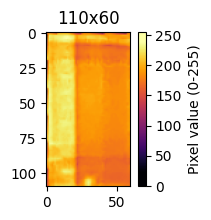

In [12]:
module = modules[0]
print(module)
module.plot()

# Définition des extracteurs

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import time

## Indicateurs statistiques "basiques"

In [14]:
# Transformeur qui renvoie le dataframe des indicateurs statistiques
class BaseStatsExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # On détermine le nom des features statistiques à extraire
        self.feature_names_ = PVModule.get_stats_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va récupérer les dict stats
        stats_dicts = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            # Stockage du dict stats
            module.extract_stats()
            stats_dicts.append(module.stats)
        # On renvoie le dataframe des dict stats
        return pd.DataFrame.from_records(stats_dicts, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des indicateurs statistiques.

In [15]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_stats()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 0.64 minutes (0.007232116152169152 secondes par module)


## Histogramme

In [16]:
# Transformeur qui renvoie le dataframe des indicateurs statistiques
class HistogramExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # On détermine le nom des features statistiques à extraire
        self.feature_names_ = PVModule.get_histogram_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va récupérer les vecteurs histogramme
        histo_dicts = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            module.extract_histogram()
            # Stockage du dict histogramme
            histo_dicts.append(module.histogram_dict)
        # On renvoie le dataframe des vecteurs stats
        return pd.DataFrame.from_records(histo_dicts, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des histogrammes.

In [17]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_histogram()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 0.05 minutes (0.0006111095620702384 secondes par module)


## Vecteurs GLCM 

In [18]:
# Transformeur qui renvoie le dataframe des caractéristiques GLCM
class GLCMExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # On détermine le nom des features GLCM à extraire
        self.feature_names_ = PVModule.get_glcm_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs GLCM
        glcm_vector_dicts = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            # Extraction et stockage du vecteur GLCM
            module.extract_glcm()
            glcm_vector_dicts.append(module.glcm_vector)
        # On renvoie le dataframe des vecteurs GLCM
        return pd.DataFrame.from_records(glcm_vector_dicts, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des vecteurs GLCM.

In [19]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_glcm()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 5.27 minutes (0.05927791645483115 secondes par module)


## Densité de contours

In [20]:
# Transformeur qui renvoie la densité de contours
class EdgeDensityExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names_ = PVModule.get_edge_density_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer la densité de contours pour chaque module PV
        edge_densities = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            # Extraction et stockage du vecteur GLCM
            module.extract_edge_density()
            edge_densities.append(module.edge_density)
        # On renvoie le dataframe des densités de contours
        return pd.DataFrame(edge_densities, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des densités de contours.

In [21]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_edge_density()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 0.04 minutes (0.0004959696908709975 secondes par module)


## Entropie

In [22]:
# Transformeur qui renvoie les caractéristiques de l'entropie de la matrice de températures du module
class EntropyExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # On détermine le nom des features Entropie à extraire
        self.feature_names_ = PVModule.get_entropy_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs caractéristiques de l'entropie
        entropy_vectors = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            # Extraction et stockage du vecteur de l'entropie
            module.extract_entropy()
            entropy_vectors.append(module.entropy_vector)
        # On renvoie le dataframe des vecteurs de l'entropie
        return pd.DataFrame.from_records(entropy_vectors, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des cartes d'entropie.

In [23]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_entropy()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 0.98 minutes (0.010991897463307214 secondes par module)


## Hot spots

In [24]:
# Transformeur qui renvoie les caractéristiques des hot spots de la matrice de températures du module
class HotSpotsExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # On détermine le nom des features 'hot spots' à extraire
        self.feature_names_ = PVModule.get_hot_spots_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs caractéristiques de l'entropie
        hot_spots_vectors = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            # Extraction et stockage du vecteur des caractéristiques des hot spots
            module.extract_hotspots()
            hot_spots_vectors.append(module.hot_spots_features)
        # On renvoie le dataframe des vecteurs des caractéristiques des hot spots
        return pd.DataFrame.from_records(hot_spots_vectors, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des hot spots.

In [25]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_hotspots()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 0.28 minutes (0.003120233298866612 secondes par module)


# Définition de l'AlbumentationsOverSampler

D'abord on importe la bibliothèque `albumentations`, puis on initialise un dictionnaire qui va mapper l'ensemble des transformations qui nous intéressent avec leur nom.

In [26]:
import albumentations as A

all_transformations = {}

c:\Users\pm219755\AppData\Local\miniforge3\envs\DataScientest_Projet\Lib\site-packages\albumentations\check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()


Enregistrement de l'ensemble des transformations créées à partir de la transformation "ToGray".

In [27]:
TRANSFORM_NAME = "ToGray"
COMP_METHODS = ["weighted_average", "from_lab", "desaturation", "average", "max", "pca"]

transformations = {}

for method_name in COMP_METHODS:

    transformation_name = f"{TRANSFORM_NAME}.{method_name}"
    transformation = A.ToGray(num_output_channels=1,
                              method=method_name,
                              p=1.)

    transformations[transformation_name] = transformation

all_transformations.update(transformations)

Enregistrement de l'ensemble des transformations créées à partir de la transformation "ImageCompression".

In [28]:
TRANSFORM_NAME = "ImgComp"
COMP_METHODS = ["jpeg", "webp"]
TOGRAY_METHODS = {
    "w_avg": "weighted_average",
    "avg": "average",
}
QUALITY = [80, 90]

transformations = {}

for method_name in COMP_METHODS:
    for quality in QUALITY:
        for togray_method_shortname, togray_method_name in TOGRAY_METHODS.items():

            transformation_name = f"{TRANSFORM_NAME}.{method_name}.{quality}.{togray_method_shortname}"
            transformation = A.Compose([
                A.ImageCompression(quality_range=[quality, quality],
                                   compression_type=method_name,                                                                                       
                                   p=1.),
                A.ToGray(num_output_channels=1,
                         method=togray_method_name,
                         p=1.),
            ])

            transformations[transformation_name] = transformation

all_transformations.update(transformations)

Enregistrement de l'ensemble des transformations créées à partir de la transformation "MedianBlur".

In [29]:
TRANSFORM_NAME = "MedianBlur"
BLUR_LIMITS = [3, 5]

transformations = {}

for blur_limit in BLUR_LIMITS:

    transformation_name = f"{TRANSFORM_NAME}.{blur_limit}"
    transformation = A.Compose([
        A.MedianBlur(blur_limit=[blur_limit, blur_limit],
                            p=1.),
        A.ToGray(num_output_channels=1,
                    method="weighted_average",
                    p=1.),
    ])

    transformations[transformation_name] = transformation

all_transformations.update(transformations)

Ici on définit quelles transformations seront appliquées selon la classe de défaut associée à chaque échantillon.

In [30]:
class_transformations = {
    "string short circuit": [
        "ToGray.from_lab",
        "ToGray.average",
        "ImgComp.jpeg.80.w_avg",
        "ImgComp.jpeg.90.w_avg",
        "ImgComp.webp.80.w_avg", 
        "ImgComp.webp.90.w_avg", 
        "ImgComp.jpeg.80.avg",
        "ImgComp.jpeg.90.avg",
        "ImgComp.webp.80.avg", 
        "ImgComp.webp.90.avg", 
        "MedianBlur.3",
    ],
    "break": [
        "ToGray.from_lab",
        "ToGray.average",
        "ImgComp.jpeg.80.w_avg",
        "ImgComp.jpeg.90.w_avg",
        "ImgComp.webp.80.w_avg", 
        "ImgComp.webp.90.w_avg", 
    ],
    "shadow": [
        "ToGray.from_lab",
        "ToGray.average",
    ],
    "Debris cover": [
        "ToGray.from_lab",
        "ToGray.average",
    ],
    "bottom dirt": [
        "ToGray.from_lab",
        "ToGray.average",
    ],
    "short circuit panel": [
        "MedianBlur.3",
    ],
}


In [31]:
import cv2

class AlbumentationsAugmenter:
    
    def __init__(self, 
                 all_transformations: dict,
                 class_transformations: dict,
                 augmented_data_subfolder: str = "augmented",
                 ):
        self.all_transformations = all_transformations
        self.class_transformations = class_transformations
        self.augmented_data_subfolder = augmented_data_subfolder
    
    def augmentation(self, module: PVModule):
        # On récupère la classe du module passé en paramètre
        defect_class = module.status
        # On en déduit la liste des transformations à appliquer
        transformations_list = self.class_transformations.get(defect_class, [])
        # On Récupère les modules "transformés" correspondants
        new_modules = []
        for transformation_name in transformations_list:
            # Définition du chemin de l'image transformée
            class_folder = f"xx{defect_class}"
            new_image_path = (module.image_path.parents[2] 
                              / self.augmented_data_subfolder 
                              / class_folder 
                              / f"{module.image_path.stem}.{transformation_name}.png")
            # Si l'image n'existe pas déjà, on la crée et on la sauvegarde
            if not new_image_path.exists():
                # Transformation
                transformation = self.all_transformations[transformation_name]
                transformed_image = transformation(image=module.color_array)['image']
                # Sauvegarde de l'image transformée
                new_image_path.parent.mkdir(exist_ok=True, parents=True)
                cv2.imwrite(new_image_path, transformed_image)
            # Ensuite on peut charge l'objet PVModule correspondant
            new_modules.append(PVModule.get_module(new_image_path))
        return new_modules

    def resample(self, X, y):
        # On itère sur chaque module du dataset X 
        # pour récupérer le chemin et la classe des nouveaux modules "augmentés"
        all_augmented_modules_dicts = []
        for row in X.itertuples(index=False):
            image_path = Path(row.Chemin)
            module = PVModule.get_module(image_path)
            augmented_modules = self.augmentation(module)
            augmented_modules_dicts = [{
                "Chemin": mod.image_path,
                "Format": mod.format,
                "Train_Test": self.augmented_data_subfolder,
                "Classe": mod.status,
                "Nom": mod.image_path.stem,
            }
                                 for mod in augmented_modules]
            all_augmented_modules_dicts += augmented_modules_dicts

        # On crée le dataframe Xy des modules augmentés
        Xy_augmentation = pd.DataFrame(all_augmented_modules_dicts) 
        # On crée le dataframe X augmenté
        X_augmented = pd.concat([X, Xy_augmentation.drop(columns=["Classe"])], axis=0)
        # On crée le vecteur y augmenté
        y_augmented = pd.concat([y, Xy_augmentation["Classe"]], axis=0)

        return X_augmented, y_augmented
    

On termine en créant le sampler à l'aide de la classe FunctionSampler de la bibliothèque `imblearn`.

In [32]:
from imblearn import FunctionSampler

# Pour que le nom réel du sampler utilisé apparaisse dans l'affichage html du pipeline, 
# on crée une classe 'AlbumentationsOverSampler' qui hérite simplement de la classe 'FunctionSampler' de imblearn
class AlbumentationsOverSampler(FunctionSampler):
    ...

albumentations_oversampler = AlbumentationsOverSampler(
    func=AlbumentationsAugmenter(all_transformations, class_transformations).resample,
    validate=False)


# Séparation du jeu de données


Train, Validation & Test.


In [33]:
TRAIN_SIZE = .8
TEST_SIZE = .2
VALIDATION_SIZE = 1. - (TRAIN_SIZE + TEST_SIZE)
RANDOM_STATE = 42
# RANDOM_STATE = None  # Leave random_state to None for non-reproducible shuffling

In [34]:
from sep24_cds_pv.features.model_selection import improved_train_test_validation_split

splits = improved_train_test_validation_split(df_pvf10, 
                                              target_col="Classe", 
                                              train_size=TRAIN_SIZE,
                                              validation_size=VALIDATION_SIZE, 
                                              test_size=TEST_SIZE, 
                                              random_state=RANDOM_STATE,
                                              stratify=True,
                                              )

In [35]:
if len(splits) == 6:
    X_train, X_test, X_validation, y_train, y_test, y_validation = splits
else:
    X_train, X_test, y_train, y_test = splits

In [36]:
total_elements = sum([len(split) for split_name, split in zip(splits._fields, splits) if split_name.startswith("y")])

def display_dataset_proportions(dataset: pd.Series):
    display(pd.concat([pd.Series(dataset).value_counts(),
                       pd.Series(dataset).value_counts(normalize=True) * 100],
                      axis=1))


for split_name, split in zip(splits._fields, splits):
    if not split_name.startswith("y"):
        continue
    print("---------------------------------")
    print(f"Split: {split_name}\n")
    nb_elements = len(split)
    print(f"Nombre d'éléments: {nb_elements}")
    print(f"Proportion du jeu complet: {nb_elements/total_elements*100:.2f}%")
    if not split.empty:
        display_dataset_proportions(split)


---------------------------------
Split: y_train

Nombre d'éléments: 4270
Proportion du jeu complet: 79.99%


,count,proportion
Classe,,
healthy panel,1165,27.283372
hot cell,676,15.831382
junction box heat,640,14.988290
substring open circuit,475,11.124122
short circuit panel,341,7.985948
bottom dirt,302,7.072600
Debris cover,268,6.276347
shadow,242,5.667447
break,104,2.435597


---------------------------------
Split: y_test

Nombre d'éléments: 1068
Proportion du jeu complet: 20.01%


,count,proportion
Classe,,
healthy panel,291,27.247191
hot cell,169,15.823970
junction box heat,160,14.981273
substring open circuit,119,11.142322
short circuit panel,86,8.052434
bottom dirt,75,7.022472
Debris cover,67,6.273408
shadow,61,5.711610
break,26,2.434457


---------------------------------
Split: y_validation

Nombre d'éléments: 0
Proportion du jeu complet: 0.00%


## Vérification du fonctionnement du sampler

On vérifie que l'utilisation du sampler permet bien de compenser les classes minoritaires selon les taux d'augmentation définis.

In [37]:
X_train_resampled, y_train_resampled = albumentations_oversampler.fit_resample(X_train, y_train)

In [38]:
display_dataset_proportions(y_train_resampled)

,count,proportion
Classe,,
healthy panel,1165,15.562383
bottom dirt,906,12.102592
Debris cover,804,10.740048
break,728,9.724820
shadow,726,9.698103
string short circuit,684,9.137056
short circuit panel,682,9.110339
hot cell,676,9.030190
junction box heat,640,8.549292


# Modélisation

## Classes complémentaires

### Sélecteur UMAP

A la différence de PCA, UMAP ne prend que des valeurs entières pour le paramètre `n_components`.

Afin d'éviter de demander un nombre de composants supérieur au nombre de features disponibles en entrée, on implémente un transformeur qui adopte le comportement suivant :
- si `n_components` est entier, on le passe tel quel au constructeur UMAP
- si `n_components` est un float, on l'utilise comme ratio du nombre de features initial pour fixer le nombre de features souhaités après réduction

In [39]:
from umap import UMAP
from math import floor

class UMAPSelector(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=2, **kwargs):
        self.n_components = n_components
        self._umap_n_components = None
        for key, value in kwargs.items():
            setattr(self, key, value)
        self.umap = None
        self._is_fitted = False

    def fit(self, X, y=None):

        if isinstance(self.n_components, float):
            if self.n_components > 1. or self.n_components < 0.:
                raise ValueError("If 'n_components' is a float, it must be in the range [0. 1.]!")
            _n_components = floor(X.shape[1] * self.n_components)
        else:
            _n_components = self.n_components
        
        self._umap_n_components = _n_components
        
        params = self.get_params()
        params["n_components"] = self._umap_n_components
        self.umap = UMAP(**params)
        self.umap.fit(X)

        # Mark as fitted
        self._is_fitted = True

        return self

    def transform(self, X):
        return self.umap.transform(X)
    
    def get_params(self, deep=True):
        # return all attributes that are parameters (sklearn convention)
        return {k: v for k, v in self.__dict__.items()
                if not k.startswith('_') and k not in ['umap']}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self
    
    def __sklearn_is_fitted__(self):
        return hasattr(self, "_is_fitted") and self._is_fitted

### Wrapper XGBoost

XGBoost ne travaille que sur des valeurs numériques.

Pour pouvoir néanmoins utiliser un classifieur XGBoost comme les autres modèles Scikit-learn, il est nécessaire de le 'wrapper' dans un estimateur qui intègre les étapes d'encodage/décodage des classes de défaut dans le vecteur 'y'.

In [40]:
from xgboost import XGBClassifier
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.exceptions import NotFittedError

class XGBClassifierWithLabelEncoding(BaseEstimator, ClassifierMixin):
    def __init__(self, **xgb_params):
        # Dynamically store XGBoost parameters
        for key, value in xgb_params.items():
            setattr(self, key, value)
        self.encoder = LabelEncoder()
        self.clf = None
        self._is_fitted = False

    def fit(self, X, y):
        y_enc = self.encoder.fit_transform(y)

        # Extract valid XGB params from self
        params = self._get_xgb_params()
        self.clf = XGBClassifier(**params)
        self.clf.fit(X, y_enc)

        # Mark as fitted and expose attributes
        self._is_fitted = True
        # self.classes_ = self.encoder.classes_
        # self.n_features_in_ = X.shape[1]
        # if hasattr(X, "columns"):
        #     self.feature_names_in_ = X.columns

        return self

    def predict(self, X):
        if not self._is_fitted:
            raise NotFittedError("This estimator is not fitted yet. Call 'fit' first.")
        y_pred_enc = self.clf.predict(X)
        return self.encoder.inverse_transform(y_pred_enc)

    def predict_proba(self, X):
        if not self._is_fitted:
            raise NotFittedError("This estimator is not fitted yet. Call 'fit' first.")
        return self.clf.predict_proba(X)

    def get_params(self, deep=True):
        return {
            k: v for k, v in self.__dict__.items()
            if not k.startswith('_') and k not in ['encoder', 'clf']
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def _get_xgb_params(self):
        valid_params = XGBClassifier().get_params()
        return {
            k: v for k, v in self.get_params().items()
            if k in valid_params
        }

    def __sklearn_is_fitted__(self):
        return hasattr(self, "_is_fitted") and self._is_fitted

## Configuration du pipeline

### Pipeline générique

In [190]:
from imblearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Pipeline générique
pipe = Pipeline([
    ('sampler', albumentations_oversampler),
    ('features', FeatureUnion([
        ('stats', BaseStatsExtractor()),
        ('histogram', HistogramExtractor()),
        ('glcm', GLCMExtractor()),
        ("edgedensity", EdgeDensityExtractor()),
        ("entropy", EntropyExtractor()),
        ("hotspots", HotSpotsExtractor()),
    ])),
    ('dropper', VarianceThreshold()),
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(k="all")),
    ('model', LogisticRegression(max_iter=1000))
],
# Le paramètre 'memory' permet de mettre en cache les transformeurs après entraînement - on gagne du temps sur le GridSearch
memory="./cache_pipeline",
# L'ajout de .set_output() permet de manipuler des dataframes pandas au lieu de simples arrays numpy à chaque étape
# Cela permet de conserver les noms des colonnes et d'y voir plus clair 
).set_output(transform="pandas")


In [191]:
pipe[:2].fit_transform(X_train, y_train).shape

(7486, 343)

L'extraction de l'ensemble des features possibles conduit à un dataframe de 343 colonnes.

### Paramétrage

Description de la méthodologie de recherche des meilleurs paramètres de pipelines.

**Remarque préalable** : \
Pour la plupart des grilles de recherche, on garde les 2 options de sampler : `[albumentations_oversampler]` et `[passthrough]`, sous la forme de 2 options séparées. Cela permet d'exécuter un GridSearch différent pour chaque option et ainsi d'obtenir 2 'best_estimator' : un avec l'augmentation de données, l'autre sans.

La recherche du meilleur pipeline se fait **classe d'estimateur par classe d'estimateur**. C'est-à-dire qu'on va d'abord rechercher le meilleur pipeline basé sur RandomForest, puis sur SVC, puis XGBoost, etc.

1. **Etape 1 - optimisation extracteurs + scalers**

    - Paramètres par défaut de l'estimateur
    - Extracteurs : pour chaque extracteur sauf `BaseStatsExtractor`, on propose l'option `drop` dans la grille de paramètres : 2^5, soit 32 combinaisons
    - Scalers : les 3 scalers possibles sont proposés : 3 combinaisons
      - Attention : a priori, l'application d'un scaling est inutile pour les estimateurs basés sur des arbres de décision comme DecisionTree, RandomForest, XGBoost, LightGBM, ...
    
    Au total, cela fait donc 2 x 96 combinaisons à évaluer pour l'étape 1.

    **A l'issue de cette étape, on peut fixer les extracteurs et le scaler à retenir.**

2. **Etape 2 - Optimisation de la réduction de dimensions / sélection de features**

    - Paramètres par défaut de l'estimateur
    - Paramètres des extracteurs et du scaler selon les résultats de l'étape précédente
    - Réduction / Sélection : on peut procéder en sous-étapes
      1. **SelectPercentile** : c'est un sélecteur, c'est-à-dire qu'il permet de sélectionner un nombre réduit (par rapport au nombre initial) de features du jeu de données. On évalue 4 ratios possibles : 20% , 50%, 80% et 100% (ce qui revient à faire "passthrough" sur l'étape de réduction).
      2. **PCA** : c'est une réduction de dimensions, c'est-à-dire que l'opération réduit le nombre de features, en projetant les features initiaux dans un nouvel espace de composantes principales. On teste 3 taux de variance expliquée : 0.9, 0.95 et 0.99.
      3. **UMAP** : c'est une technique réduction de dimensions non-linéaire. Ici, l'algorithme est plus complexe et il peut être intéressant de tester différentes valeurs sur les 3 paramètresles plus influents suivants : `n_components`, `n_neighbors` et `min_dist`. 3 valeurs pour chaque nous donnent 27 combinaisons.
      
      **Attention** : pour utiliser les techniques PCA ou UMAP il faut au préalable normaliser les features, même pour les estimateurs qui a priori ne le nécessitent pas (en théorie l'opération de normalisation ne change pas leurs performances).

    Au total, on évalue donc 4, puis 3 puis 27 combinaisons, 2 fois puisqu'on a choisi de conserver la double option "avec augmentation" / "sans augmentation". Soit 68 combinaisons.

    **A l'issue de cette étape on peut fixer le paramétrage de la sélection de features ou réduction de dimensions. Le critère de choix étant le meilleur compromis entre la performance et le temps d'entraînement.** En effet, la réduction du nombre de features à cette étape peut être intéressante en permettant de réduire le temps d'entraînement de l'estimateur, mais cela réduit souvent les performances de celui-ci.

3. **Etape 3. Optimisation de l'estimateur**

    - Paramètres des extracteurs et du scaler selon les résultats de l'étape 1.
    - Paramètres de sélection / réduction de dimensions selon les résultats de l'étape 2.
    - Le choix des paramètres à optimiser dépend évidemment de l'estimateur en cours d'évaluation mais aussi du contexte des données (nombre d'échantillons, nombre de features) et du problème à résoudre (dans notre cas : classification, 10 classes différentes, classes plus ou moins déséquilibrées - selon l'application de l'augmentation).


#### Samplers

Paramétrage des samplers à évaluer.

In [192]:
sampler_param_grid = [
    {
        'sampler': [
            albumentations_oversampler,
            # "passthrough",
            ],
    },
    {
        'sampler': ['passthrough'],
    }
]

#### Extracteurs

Paramétrage des extracteurs.

In [193]:
extractors_param_grid = [
    {
        "features__stats": [BaseStatsExtractor()],
        "features__edgedensity": [
            EdgeDensityExtractor(),
            # "drop",
            ],
        "features__entropy": [
            EntropyExtractor(),
            # "drop",
            ],
        "features__glcm": [
            GLCMExtractor(),
            # "drop",
            ],
        "features__histogram": [
            # HistogramExtractor(),
            "drop",
            ],
        "features__hotspots": [
            # HotSpotsExtractor(),
            "drop",
            ],
    },
    # {
    #     "features__stats": [BaseStatsExtractor()],
    #     "features__edgedensity": [EdgeDensityExtractor(),],
    #     "features__entropy": [EntropyExtractor(),],
    #     "features__glcm": [GLCMExtractor()],
    #     "features__histogram": [HistogramExtractor()],
    #     "features__hotspots": [HotSpotsExtractor(),],
    # },
]

#### Scalers

Paramétrage des scalers.

In [194]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scaler_param_grid = [
    {    
        "scaler": [
            "passthrough",
            # StandardScaler().set_output(transform="pandas"),
            # MinMaxScaler().set_output(transform="pandas"),
            # RobustScaler().set_output(transform="pandas"),
        ]
    },
    {    
        "scaler": [
            # "passthrough",
            StandardScaler().set_output(transform="pandas"),
            # MinMaxScaler().set_output(transform="pandas"),
            # RobustScaler().set_output(transform="pandas"),
        ]
    },
]

#### Selecteurs (Réduction)

Paramétrage de la réduction de dimensions.

In [195]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_classif
from sklearn.decomposition import PCA

selector_param_grid = [
    {
        'selector': ['passthrough'],
    },
    # {
    #     'selector': [SelectKBest()],
    #     # k permet de choisir le nombre de noyaux cible (nombre de features au final)
    #     # 'selector__k' : [50, 100, 150, 200, 'all'],
    #     # 'selector__k' : ['all'],
    # },
    # {
    #     # SelectePercentile : approche similaire à SelectKBest
    #     'selector': [SelectPercentile(mutual_info_classif)],
    #     # 'percentile' permet de déterminer le nombre de features à conserver, en pourcentage du nombre initial
    #     'selector__percentile' : [20, 50, 80, 100],
    #     # 'selector__percentile' : [80],
    # },
    # {
    #     # Analyse en Composantes Principales
    #     'selector': [PCA()],
    #     # 'n_components', si donné en float, permet de choisir le ratio de variance expliquée à conserver
    #     'selector__n_components' : [0.9, 0.95, 0.99],
    # },
    # {
    #     # Uniform Manifold Approximation and Projection
    #     # 'selector': [UMAPSelector(random_state=42)],
    #     'selector': [UMAPSelector()],
    #     # 'n_components' permet de choisir le nombre de noyaux cible (nombre de features au final)
    #     # 'selector__n_components' : [0.5, 0.8, 1.],
    #     'selector__n_components' : [0.5, 0.8],
    #     'selector__n_neighbors' : [5, 10, 15],
    #     'selector__min_dist' : [0.5, 0.8, 0.99],
    # },
]

#### Estimateurs

Paramétrage des estimateurs (modèles).

In [ ]:
# Estimateurs à évaluer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

model_param_grid = [
    {
        # Très bonnes performances mais plutôt très très lent... !
        # A évaluer en suivant la méthodologie ?
        'model': [CatBoostClassifier()],
    },
    # {
    #     'model': [LogisticRegression(max_iter=1000)],
    #     'model__C': [100],
    #     # 'model__solver': ['lbfgs', 'saga'],
    #     # 'model__C': [10, 100],
    #     # 'model__penalty': ['l2'],
    # },
    # {
    #     'model': [KNeighborsClassifier()],
    #     # "model__n_neighbors": np.arange(2, 20),
    #     # "model__metric": ["minkowski", "manhattan", "chebyshev"],
    #     # "model__weights": ["uniform", "distance"],
    #     # "model__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    #     # "model__n_neighbors": [12],
    #     # "model__metric": ["manhattan"],
    #     # "model__weights": ["distance"],
    #     # "model__algorithm": ["auto"],
    # },
    # {
    #     'model': [AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5))],
    #     # "model__n_estimators": [190],
    #     # "model__learning_rate": [1.],
    # },
    # {
    #     'model': [BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5))],
    #     # "model__n_estimators": np.arange(100, 500, 100),
    # },
    # {
    #     'model': [MLPClassifier(max_iter=10000, alpha=0.0001, early_stopping=True)],
    #     'model__hidden_layer_sizes': [
    #         # (10,),
    #         # (50,),
    #         # (100,),
    #         # (10, 10),
    #         # (50, 50),
    #         (100, 100),
    #         # (10, 10, 10),
    #         # (50, 50, 50),
    #         # (100, 100, 100),
    #         ],
    #     # 'model__solver': ["adam", "lbfgs", "sgd"],
    #     # "model__activation": ["logistic", "tanh", "relu"],
    #     'model__solver': ["lbfgs"],
    #     "model__activation": ["tanh"],
    # },
    # {
    #     # Bonnes performances mais plutôt lent
    #     'model': [LGBMClassifier()],
    #     # Paramètres par défaut
    #     "model__objective": ['multiclass'],
    #     # Paramètres optimaux trouvés lors de la phase exploratoire
    #     "model__metric": ['multi_logloss'],  # ou 'multi_error'
    #     "model__num_leaves": [127],  # Par défaut: 31
    #     "model__min_data_in_leaf": [20],  # Par défaut: 20
    #     "model__learning_rate": [0.1],  # Par défaut: 0.1
    #     "model__class_weight": [None],  # Par défaut: None
    #     # Grille d'exploration
    #     # "model__num_leaves": [15, 31, 63, 127],
    #     # "model__min_data_in_leaf": [5, 10, 20, 50, 100],
    #     # "model__learning_rate": [0.01, 0.05, 0.1, 0.2, 0.5],
    #     # "model__class_weight": ["balanced", None]
    #     # "model__metric": ['multi_logloss', 'multi_error'],
    # },
    # {
    #     'model': [SVC()],
    #     # Paramètres optimaux trouvés lors de la phase exploratoire
    #     'model__C': [10],  # Par défaut: 1.
    #     'model__kernel': ['rbf'],  # Par défaut: 'rbf'
    #     "model__gamma": ["scale"],  # Par défaut: 'scale'
    #     "model__class_weight": [None],  # Par défaut: None
    #     "model__shrinking": [True],  # Par défaut: True
    #     # Grille d'exploration
    #     # 'model__C': [0.01, 0.1, 1, 10, 100, 1000],
    #     # 'model__kernel': ['linear', 'rbf', 'poly'],
    #     # "model__degree": [2, 3, 4, 5],  # Par défaut: 3 (pour kernel 'poly' seulement)
    #     # "model__gamma": ["scale", "auto", 0.001, 0.1, 0.5, 1.],
    #     # "model__class_weight": ["balanced", None]
    #     # "model__shrinking": [True, False],
    # },
    # {
    #     'model': [XGBClassifierWithLabelEncoding()],
    #     # tree_method='auto' et eval_metric='logloss' sont les valeurs par défaut du XGBClassifier
    #     'model__tree_method': ['auto'],
    #     'model__eval_metric': ['logloss'],
    #     # Attention : sans random_state fixe, XGBoost garde une part d'aléatoire et les résultats ne sont pas rigoureusement reproductibles
    #     'model__random_state': [42],
    #     # Paramètres optimaux trouvés lors de la phase exploratoire
    #     'model__max_depth': [6],  # Par défaut: 6
    #     'model__min_child_weight': [1],  # Par défaut: 1
    #     'model__colsample_bytree': [1.],  # Par défaut: 1
    #     'model__subsample': [1.0],  # Par défaut: 1.
    #     'model__learning_rate': [0.3],  # (ou eta) Par défaut: 0.3
    #     'model__n_estimators': [100],  # Par défaut: 100
    #     # Grille d'exploration
    #     # 'model__max_depth': [4, 6, 8],
    #     # 'model__min_child_weight': [1, 6, 12],
    #     # 'model__subsample': [0.5, 0.7, 0.9, 1.0],
    #     # 'model__colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    #     # 'model__n_estimators': [100, 200, 300, 500, 600, 700, 800, 900, 1000],
    #     # 'model__learning_rate': [0.01, 0.05, 0.1, 0.3],
    # },
    # {
    #     'model': [DecisionTreeClassifier()],
    #     # Attention : sans random_state fixe, DecisionTree garde une part d'aléatoire et les résultats ne sont pas rigoureusement reproductibles
    #     'model__random_state': [32],
    #     # Paramètres optimaux trouvés lors de la phase exploratoire
    #     "model__max_depth": [12],  # Par défaut: None
    #     "model__min_samples_split": [2],  # Par défaut: 2
    #     "model__min_samples_leaf": [1],  # Par défaut: 1
    #     "model__max_features": [None],  # Par défaut: None
    #     "model__class_weight": [None],  # Par défaut: None
    #     "model__criterion": ["gini"],  # Par défaut: "gini"
    #     # Grille d'exploration
    #     # "model__max_depth": [None, 10, 12, 15, 20],  # Par défaut: None
    #     # "model__min_samples_split": [2, 5, 10, 20, 50],  # Par défaut: 2
    #     # "model__min_samples_leaf": [1, 2, 5, 10, 20],  # Par défaut: 1
    #     # "model__max_features": ["sqrt", "log2", 0.2, 0.5, None],  # Par défaut: None
    #     # "model__class_weight": [None, "balanced"],  # Par défaut: None
    #     # "model__criterion": ["gini", "entropy"],  # Par défaut: "gini"
    # },
    # {
    #     'model': [RandomForestClassifier()],
    #     # Attention : sans random_state fixe, RandomForest garde une part d'aléatoire et les résultats ne sont pas rigoureusement reproductibles
    #     'model__random_state': [42],
    #     # Paramètres optimaux trouvés lors de la phase exploratoire
    #     'model__n_estimators': [95],
    #     "model__criterion": ["gini"],
    #     "model__max_depth": [17],
    #     "model__min_samples_split": [2],
    #     "model__min_samples_leaf": [2],
    #     "model__class_weight": ["balanced"],
    #     # Grille d'exploration
    #     # 'model__n_estimators': np.arange(90, 110, 5),
    #     # "model__criterion": ["entropy", "gini", "log_loss"],
    #     # "model__max_depth": [17, 18, 19, 20, None],
    #     # # Paramètres additionnels
    #     # "model__min_samples_split": [2, 5, 10],
    #     # "model__min_samples_leaf": [1, 2, 4],
    #     # "model__class_weight": [None, "balanced"],
    # },
]

### Combinaison de l'ensemble des paramètres

In [197]:
param_grids = []

for model_dict in model_param_grid:
    for extractor_dict in extractors_param_grid:
        for scaler_dict in scaler_param_grid:
            for selector_dict in selector_param_grid:
                for sampler_dict in sampler_param_grid:
                    full_dict = {}
                    full_dict.update(model_dict)
                    full_dict.update(extractor_dict)
                    full_dict.update(scaler_dict)
                    full_dict.update(selector_dict)
                    full_dict.update(sampler_dict)
                    param_grids.append(full_dict)

In [198]:
len(param_grids)

4

### Fonctions d'extraction des caractéristiques du pipeline

In [199]:
# Type de modèle
def extract_model_name(pipeline):
    model = pipeline[5]
    return model.__class__.__name__ if model is not None else 'unknown'

# Sampler
def extract_sampler_name(pipeline):
    sampler = pipeline[0]
    return sampler.__class__.__name__ if not isinstance(sampler, str) else 'noSampling'

# Extracteurs / Features
def extract_extractor_names(pipeline):
    extractors_dict = pipeline[1].named_transformers
    extractor_strings = []
    for feature_key, extractor in extractors_dict.items():
        extractor_string = feature_key.capitalize()
        extractor_string = f"no{extractor_string}" if isinstance(extractor, str) else extractor_string
        extractor_strings.append(extractor_string)
    return "_".join(extractor_strings)

# Scaler
def extract_scaler_name(pipeline):
    scaler = pipeline[3]
    return scaler.__class__.__name__ if not isinstance(scaler, str) else 'noScaling'

# Selector
def extract_selector_name(pipeline):
    selector = pipeline[4]
    return selector.__class__.__name__ if not isinstance(selector, str) else 'noReduction'

# Concaténation de l'ensemble des caractéristiques
def get_pipeline_shortdescription(pipeline):

    model_name = extract_model_name(pipeline)
    sampler_name = extract_sampler_name(pipeline)
    features = extract_extractor_names(pipeline)
    scaler_name = extract_scaler_name(pipeline)
    selector_name = extract_selector_name(pipeline)
    
    return f"{model_name}_{sampler_name}_{features}_{scaler_name}_{selector_name}"


## Activation de MLflow

In [200]:
import arrow

current_dt = arrow.utcnow()

if ACTIVATE_MLFLOW:

    import mlflow
    import logging

    # Configuration du serveur MLflow
    mlflow.set_tracking_uri(MLFLOW_URI)

    # Définition des noms des Experiments
    # MLFLOW_EXPERIMENT_NAME_PATTERN = "PVF10_MLstats_{model_name}_{date_string}"
    MLFLOW_EXPERIMENT_NAME_PATTERN = "PVF10_MLstats_{model_name}"

    # # Suppress MLflow logs
    mlflow_logger = logging.getLogger('mlflow')
    mlflow_logger.setLevel(logging.WARNING)
    logging.getLogger('mlflow.utils.requirements_utils').setLevel(logging.ERROR)
    

## Validation croisée

### Fonction d'exécution du GridSearchCV

In [201]:
import time
import tempfile
from pprint import pprint
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

from sep24_cds_pv.features.model_selection import display_results


# Exécution du GridSearch
def execute_gridsearch(pipeline_param_grid):

    start = time.time()

    base_model = pipeline_param_grid.get('model')[0]
    model_name = base_model.__class__.__name__
    
    print("-------------------------------------------------------------------------")
    print(f"Evaluation des pipelines basés sur {model_name}")
    print("-------------------------------------------------------------------------")
    print()

    grid = GridSearchCV(estimator=pipe, 
                        param_grid=pipeline_param_grid, 
                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                        scoring={'accuracy': 'accuracy','f1_macro': 'f1_macro'},
                        refit='f1_macro', 
                        return_train_score=True,
                        n_jobs=-1, 
                        verbose=1)
    grid.fit(X_train, y_train)

    end = time.time()
    print(f"Temps nécessaire : {(end - start)/60:.2f} minutes")

    display(grid)

    # Affichage des résultats (classement par f1-score macro)
    print()
    print("Résultats obtenus par le GridSearch (sur le jeu d'apprentissage) :")
    print("Meilleurs paramètres (f1 macro) : ")
    pprint(grid.best_params_)
    print("Meilleur score (f1 macro): ", grid.best_score_)

    results = pd.DataFrame(grid.cv_results_)

    # Ajout de la description macro de chaque pipeline évalué
    for idx, params in results['params'].items():
        c_pipe = clone(grid.estimator)
        c_pipe.set_params(**params)
        c_pipe_description = get_pipeline_shortdescription(c_pipe)
        results.loc[idx, "pipeline_description"] = c_pipe_description

    # Calcul des prévisions sur le jeu de test
    y_test_pred = grid.best_estimator_.predict(X_test)

    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1_macro = f1_score(y_test, y_test_pred, average="macro")
    test_f1_weighted = f1_score(y_test, y_test_pred, average="weighted")
    test_recall_macro = recall_score(y_test, y_test_pred, average="macro")
    test_recall_weighted = recall_score(y_test, y_test_pred, average="weighted")
    test_precision_macro = precision_score(y_test, y_test_pred, average="macro")
    test_precision_weighted = precision_score(y_test, y_test_pred, average="weighted")
       
    # Ajouter les scores obtenus sur le jeu de test, pour le meilleur estimateur trouvé
    best_idx = grid.best_index_
    results.loc[best_idx, "test_accuracy"] = test_accuracy
    results.loc[best_idx, "test_f1_macro"] = test_f1_macro
    results.loc[best_idx, "test_f1_weighted"] = test_f1_weighted
    results.loc[best_idx, "test_recall_macro"] = test_recall_macro
    results.loc[best_idx, "test_recall_weighted"] = test_recall_weighted
    results.loc[best_idx, "test_precision_macro"] = test_precision_macro
    results.loc[best_idx, "test_precision_weighted"] = test_precision_weighted

    # Ajout du nombre de features avant et après sélection (réduction de dimension), pour le meilleur estimateur
    n_features_pre_selector = grid.best_estimator_[:4].transform(X_test).shape[1]
    results.loc[best_idx, "n_features_pre_selector"] = n_features_pre_selector
    n_features_post_selector = grid.best_estimator_[:5].transform(X_test).shape[1]
    results.loc[best_idx, "n_features_post_selector"] = n_features_post_selector

    # Affichage des résultats
    print()
    print("--------------------------------")
    print("Résultats obtenus sur le jeu de test, pour le meilleur estimateur trouvé :")

    cm_figure, cr_text, cr_dict = display_results(y_test, y_test_pred)

    display(results[['pipeline_description',
                     'rank_test_f1_macro',
                     'params', 
                     'mean_fit_time', 'mean_score_time', 
                     'mean_test_accuracy', 'std_test_accuracy', 
                     'mean_test_f1_macro', 'std_test_f1_macro',
                     "test_accuracy", "test_f1_macro", "test_f1_weighted",
                     ]]
            .sort_values('mean_test_f1_macro', ascending=False))

    return grid, results, cm_figure, cr_text, cr_dict


### Fonctions de log de MLflow

In [202]:
if ACTIVATE_MLFLOW:

    import mlflow.sklearn
    import mlflow.sklearn.utils

    def mlflow_log_standard(current_results, i):
        """Log info for standard run"""

        params = current_results.loc[i, 'params']

        # Log pipeline description as tag
        mlflow.set_tag("description", current_results.loc[i, "pipeline_description"])

        # Log hyperparameters
        mlflow.log_params(params)

        # Log mean and std scores, mean and std times, ranks, split_scores, n_features
        for name in current_results.columns:
            if name.startswith(("mean_test_", "rank_test_", "std_test_", "n_features_")) or name.endswith("_time"):
                mlflow.log_metric(name, current_results.loc[i, name])

        mlflow.set_tag("is_best", False)


    def mlflow_log_best(child_run, current_results, i, current_grid, figure, report_text, report_dict):
        """Log info for best run"""

        # Log the model
        best_model = current_grid.best_estimator_
        mlflow.sklearn.log_model(best_model, artifact_path="model", input_example=X_train[["Chemin"]])
        mlflow.set_tag("is_best", True)

        # Log pipeline html representation
        mlflow.sklearn.utils._log_estimator_html(child_run.info.run_id, best_model)

        # Log test metrics
        for score_name in [name for name in current_results.columns if name.startswith("test_")]:
            mlflow.log_metric(score_name, current_results.loc[i, score_name])
        # Log classification matrix
        with tempfile.TemporaryDirectory() as tmp_dir:
            cm_path = Path(tmp_dir) / "confusion_matrix.png"
            figure.savefig(cm_path)
            mlflow.log_artifact(cm_path)
        # Log classification reports
        mlflow.log_text(report_text, "classification_report.txt")
        mlflow.log_dict(report_dict, "classification_report.yaml")

        mlflow.set_tag("is_best", True)


### Exécution du GridSearchCV


Param_grid 1/4
-------------------------------------------------------------------------
Evaluation des pipelines basés sur LGBMClassifier
-------------------------------------------------------------------------

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,003531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17760
[LightGBM] [Info] Number of data points in the train set: 7486, number of used features: 76
[LightGBM] [Info] Start training from score -2,231191
[LightGBM] [Info] Start training from score -2,111751
[LightGBM] [Info] Start training from score -2,330489
[LightGBM] [Info] Start trainin

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('sampler',
                                        AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x00000200144A3770>>,
                                                                  validate=False)),
                                       ('features',
                                        FeatureUnion(transformer_list=[('stats',
                                                                        BaseSt...
                         'model__objective': ['multiclass'],
                         'sampler': [AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x00000200144A3770>>,
                                                               validate=False)],
                         'scaler': ['passthrough'],
                         'selector': ['passthrough']},
             refit='f1_macro', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=1)


Résultats obtenus par le GridSearch (sur le jeu d'apprentissage) :
Meilleurs paramètres (f1 macro) : 
{'features__edgedensity': EdgeDensityExtractor(),
 'features__entropy': EntropyExtractor(),
 'features__glcm': GLCMExtractor(),
 'features__histogram': 'drop',
 'features__hotspots': 'drop',
 'features__stats': BaseStatsExtractor(),
 'model': LGBMClassifier(),
 'model__class_weight': None,
 'model__learning_rate': 0.1,
 'model__metric': 'multi_logloss',
 'model__min_data_in_leaf': 20,
 'model__num_leaves': 127,
 'model__objective': 'multiclass',
 'sampler': AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x00000200144A3770>>,
                          validate=False),
 'scaler': 'passthrough',
 'selector': 'passthrough'}
Meilleur score (f1 macro):  0.72177952718288
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20

-----------------------

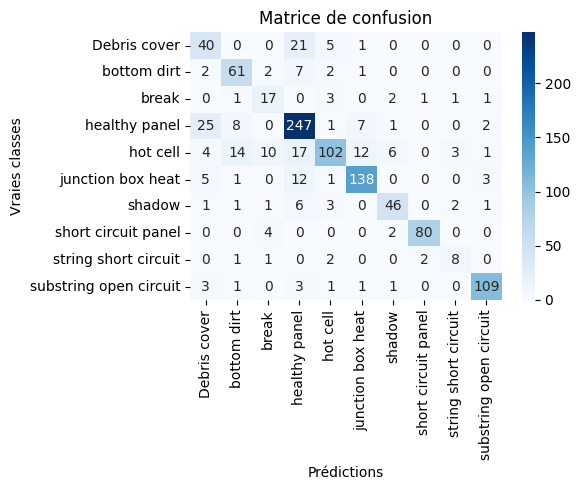

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.50      0.60      0.54        67
           bottom dirt       0.69      0.81      0.75        75
                 break       0.49      0.65      0.56        26
         healthy panel       0.79      0.85      0.82       291
              hot cell       0.85      0.60      0.71       169
     junction box heat       0.86      0.86      0.86       160
                shadow       0.79      0.75      0.77        61
   short circuit panel       0.96      0.93      0.95        86
  string short circuit       0.57      0.57      0.57        14
substring open circuit       0.93      0.92      0.92       119

              accuracy                           0.79      1068
             macro avg       0.74      0.76      0.75      1068
          weighted avg       0.80      0.79      0.79      1068



,pipeline_description,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,test_accuracy,test_f1_macro,test_f1_weighted
0,LGBMClassifier_AlbumentationsOverSampler_Stats...,1,{'features__edgedensity': EdgeDensityExtractor...,45.092124,0.686312,0.804684,0.017857,0.72178,0.022802,0.794007,0.745134,0.794841


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
🏃 View run casual-goose-646_0 at: http://localhost:8080/#/experiments/383446338330806377/runs/bd7e9fad218a4fd2959e18c9e0b51d6b
🧪 View experiment at: http://localhost:8080/#/experiments/383446338330806377
🏃 View run casual-goose-646 at: http://localhost:8080/#/experiments/383446338330806377/runs/bbd0a5f46f4d4b4daf9e710d6563c341
🧪 View experiment at: http://localhost:8080/#/experiments/383446338330806377

Param_grid 2/4
-------------------------------------------------------------------------
Evaluation des pipelines basés sur LGBMClassifier
-------------------------------------------------------------------------

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will b

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('sampler',
                                        AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x00000200144A3770>>,
                                                                  validate=False)),
                                       ('features',
                                        FeatureUnion(transformer_list=[('stats',
                                                                        BaseSt...
                         'model__class_weight': [None],
                         'model__learning_rate': [0.1],
                         'model__metric': ['multi_logloss'],
                         'model__min_data_in_leaf': [20],
                         'model__num_leaves': [127],
                         'model__objective': ['multiclass'],
                         'sampler': ['passthrough'], 'scaler': ['passthrough'],
                         'selector': ['passthrough']},
             refit='f1_macro', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=1)


Résultats obtenus par le GridSearch (sur le jeu d'apprentissage) :
Meilleurs paramètres (f1 macro) : 
{'features__edgedensity': EdgeDensityExtractor(),
 'features__entropy': EntropyExtractor(),
 'features__glcm': GLCMExtractor(),
 'features__histogram': 'drop',
 'features__hotspots': 'drop',
 'features__stats': BaseStatsExtractor(),
 'model': LGBMClassifier(metric='multi_logloss', min_data_in_leaf=20, num_leaves=127,
               objective='multiclass'),
 'model__class_weight': None,
 'model__learning_rate': 0.1,
 'model__metric': 'multi_logloss',
 'model__min_data_in_leaf': 20,
 'model__num_leaves': 127,
 'model__objective': 'multiclass',
 'sampler': 'passthrough',
 'scaler': 'passthrough',
 'selector': 'passthrough'}
Meilleur score (f1 macro):  0.7430855906362792
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20

--------------------------------
Résultats obtenus sur le jeu de test, pour le meilleur estimateur

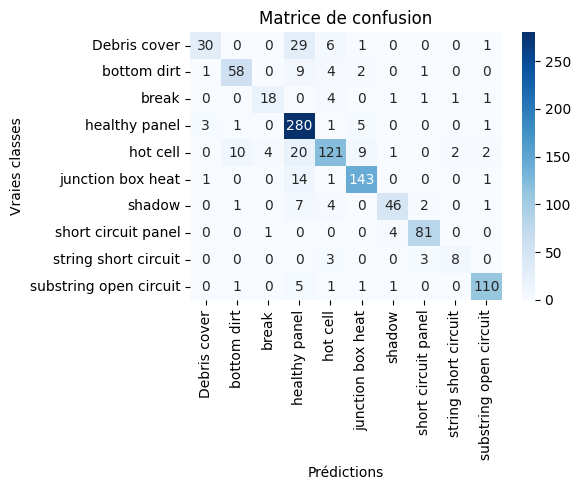

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.86      0.45      0.59        67
           bottom dirt       0.82      0.77      0.79        75
                 break       0.78      0.69      0.73        26
         healthy panel       0.77      0.96      0.85       291
              hot cell       0.83      0.72      0.77       169
     junction box heat       0.89      0.89      0.89       160
                shadow       0.87      0.75      0.81        61
   short circuit panel       0.92      0.94      0.93        86
  string short circuit       0.73      0.57      0.64        14
substring open circuit       0.94      0.92      0.93       119

              accuracy                           0.84      1068
             macro avg       0.84      0.77      0.79      1068
          weighted avg       0.84      0.84      0.83      1068



,pipeline_description,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,test_accuracy,test_f1_macro,test_f1_weighted
0,LGBMClassifier_noSampling_Stats_noHistogram_Gl...,1,{'features__edgedensity': EdgeDensityExtractor...,44.338681,0.428315,0.826698,0.01128,0.743086,0.023945,0.838015,0.794433,0.832293


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
🏃 View run bittersweet-fish-532_0 at: http://localhost:8080/#/experiments/383446338330806377/runs/def39261187140e284df188d8890283b
🧪 View experiment at: http://localhost:8080/#/experiments/383446338330806377
🏃 View run bittersweet-fish-532 at: http://localhost:8080/#/experiments/383446338330806377/runs/2aa48d4cdf8947fdb2416fd95eecf41a
🧪 View experiment at: http://localhost:8080/#/experiments/383446338330806377

Param_grid 3/4
-------------------------------------------------------------------------
Evaluation des pipelines basés sur LGBMClassifier
-------------------------------------------------------------------------

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=2

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('sampler',
                                        AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x00000200144A3770>>,
                                                                  validate=False)),
                                       ('features',
                                        FeatureUnion(transformer_list=[('stats',
                                                                        BaseSt...
                         'model__objective': ['multiclass'],
                         'sampler': [AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x00000200144A3770>>,
                                                               validate=False)],
                         'scaler': [StandardScaler()],
                         'selector': ['passthrough']},
             refit='f1_macro', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=1)


Résultats obtenus par le GridSearch (sur le jeu d'apprentissage) :
Meilleurs paramètres (f1 macro) : 
{'features__edgedensity': EdgeDensityExtractor(),
 'features__entropy': EntropyExtractor(),
 'features__glcm': GLCMExtractor(),
 'features__histogram': 'drop',
 'features__hotspots': 'drop',
 'features__stats': BaseStatsExtractor(),
 'model': LGBMClassifier(metric='multi_logloss', min_data_in_leaf=20, num_leaves=127,
               objective='multiclass'),
 'model__class_weight': None,
 'model__learning_rate': 0.1,
 'model__metric': 'multi_logloss',
 'model__min_data_in_leaf': 20,
 'model__num_leaves': 127,
 'model__objective': 'multiclass',
 'sampler': AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x00000200144A3770>>,
                          validate=False),
 'scaler': StandardScaler(),
 'selector': 'passthrough'}
Meilleur score (f1 macro):  0.7227461327219566
[LightGBM] [Warning] min_data_in_leaf is se

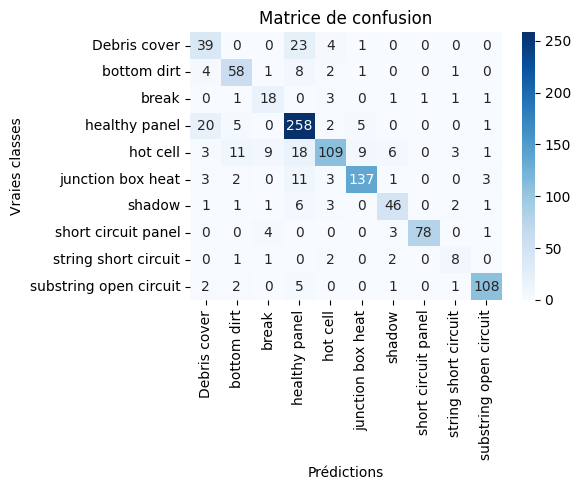

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.54      0.58      0.56        67
           bottom dirt       0.72      0.77      0.74        75
                 break       0.53      0.69      0.60        26
         healthy panel       0.78      0.89      0.83       291
              hot cell       0.85      0.64      0.73       169
     junction box heat       0.90      0.86      0.88       160
                shadow       0.77      0.75      0.76        61
   short circuit panel       0.99      0.91      0.95        86
  string short circuit       0.50      0.57      0.53        14
substring open circuit       0.93      0.91      0.92       119

              accuracy                           0.80      1068
             macro avg       0.75      0.76      0.75      1068
          weighted avg       0.81      0.80      0.81      1068



,pipeline_description,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,test_accuracy,test_f1_macro,test_f1_weighted
0,LGBMClassifier_AlbumentationsOverSampler_Stats...,1,{'features__edgedensity': EdgeDensityExtractor...,62.381833,0.467464,0.803279,0.015087,0.722746,0.018626,0.804307,0.750467,0.805055


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
🏃 View run traveling-boar-256_0 at: http://localhost:8080/#/experiments/383446338330806377/runs/49b3f1335f314b2bb535e122bc1e5b83
🧪 View experiment at: http://localhost:8080/#/experiments/383446338330806377
🏃 View run traveling-boar-256 at: http://localhost:8080/#/experiments/383446338330806377/runs/4ba8e0d43ecd4b969dbb0d2aba338b71
🧪 View experiment at: http://localhost:8080/#/experiments/383446338330806377

Param_grid 4/4
-------------------------------------------------------------------------
Evaluation des pipelines basés sur LGBMClassifier
-------------------------------------------------------------------------

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 wi

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('sampler',
                                        AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x00000200144A3770>>,
                                                                  validate=False)),
                                       ('features',
                                        FeatureUnion(transformer_list=[('stats',
                                                                        BaseSt...
                         'model__class_weight': [None],
                         'model__learning_rate': [0.1],
                         'model__metric': ['multi_logloss'],
                         'model__min_data_in_leaf': [20],
                         'model__num_leaves': [127],
                         'model__objective': ['multiclass'],
                         'sampler': ['passthrough'],
                         'scaler': [StandardScaler()],
                         'selector': ['passthrough']},
             refit='f1_macro', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=1)


Résultats obtenus par le GridSearch (sur le jeu d'apprentissage) :
Meilleurs paramètres (f1 macro) : 
{'features__edgedensity': EdgeDensityExtractor(),
 'features__entropy': EntropyExtractor(),
 'features__glcm': GLCMExtractor(),
 'features__histogram': 'drop',
 'features__hotspots': 'drop',
 'features__stats': BaseStatsExtractor(),
 'model': LGBMClassifier(metric='multi_logloss', min_data_in_leaf=20, num_leaves=127,
               objective='multiclass'),
 'model__class_weight': None,
 'model__learning_rate': 0.1,
 'model__metric': 'multi_logloss',
 'model__min_data_in_leaf': 20,
 'model__num_leaves': 127,
 'model__objective': 'multiclass',
 'sampler': 'passthrough',
 'scaler': StandardScaler(),
 'selector': 'passthrough'}
Meilleur score (f1 macro):  0.7318843548547778
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20

--------------------------------
Résultats obtenus sur le jeu de test, pour le meilleur estimat

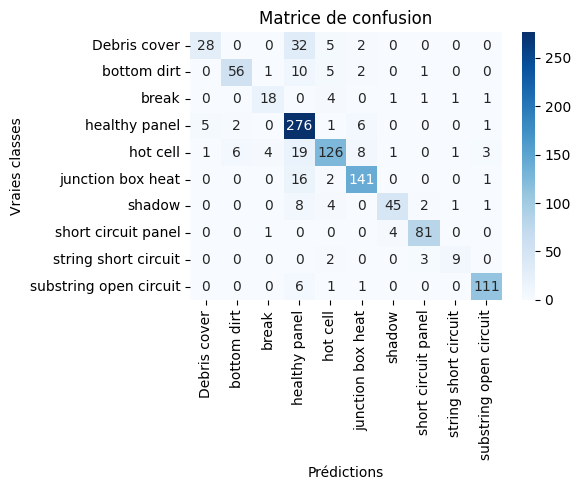

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.82      0.42      0.55        67
           bottom dirt       0.88      0.75      0.81        75
                 break       0.75      0.69      0.72        26
         healthy panel       0.75      0.95      0.84       291
              hot cell       0.84      0.75      0.79       169
     junction box heat       0.88      0.88      0.88       160
                shadow       0.88      0.74      0.80        61
   short circuit panel       0.92      0.94      0.93        86
  string short circuit       0.75      0.64      0.69        14
substring open circuit       0.94      0.93      0.94       119

              accuracy                           0.83      1068
             macro avg       0.84      0.77      0.80      1068
          weighted avg       0.84      0.83      0.83      1068



,pipeline_description,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,test_accuracy,test_f1_macro,test_f1_weighted
0,LGBMClassifier_noSampling_Stats_noHistogram_Gl...,1,{'features__edgedensity': EdgeDensityExtractor...,44.33991,0.525178,0.823419,0.011217,0.731884,0.025421,0.83427,0.795396,0.828815


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
🏃 View run spiffy-bear-699_0 at: http://localhost:8080/#/experiments/383446338330806377/runs/437cd654863948659777c9bd012a2841
🧪 View experiment at: http://localhost:8080/#/experiments/383446338330806377
🏃 View run spiffy-bear-699 at: http://localhost:8080/#/experiments/383446338330806377/runs/ae7d7f50e987484f8b38a1a8c3e3c81b
🧪 View experiment at: http://localhost:8080/#/experiments/383446338330806377


In [203]:
from joblib import parallel_backend
import warnings

results_list = []

mlflow_client = mlflow.tracking.MlflowClient()

for param_idx, param_grid in enumerate(param_grids):

    print()
    print(f"Param_grid {param_idx+1}/{len(param_grids)}")

    # with parallel_backend('loky'):  # Paramétrage par défaut - multiprocessing
    with parallel_backend('threading'):  # Important pour permettre le "partage" de la classe PVModule entre tous les jobs

        with warnings.catch_warnings():

            # Filtrage des FutureWarnings émis par scikit-learn / UMAP utilise un nom de paramètre prochainement déprécié
            warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn", message=r"^'force_all_finite' was renamed.*")
            # Filtrage des UserWarnings émis par joblib (probablement une opération de lecture du cache qui dure trop longtemps)
            warnings.filterwarnings("ignore", category=UserWarning, module="joblib", message=r"^Persisting input arguments took.*")
        
            # Exécution du GridSearchCV
            current_grid, current_results, figure, report_text, report_dict = execute_gridsearch(param_grid)

    # Ajout des résultats courants à la liste
    results_list.append(current_results)

    if ACTIVATE_MLFLOW:

        base_model = param_grid.get('model')[0]
        model_name = base_model.__class__.__name__
        
        mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME_PATTERN.format(model_name=model_name,
                                                                    # date_string=current_dt.format('YYYYMMDD_HHmm'),
                                                                    # date_string=current_dt.format('YYYYMMDD'),
                                                                    )
                              )
        mlflow.set_experiment_tag("estimator", model_name)

        with mlflow.start_run() as parent_run:

            n_candidates = len(current_results['params'])
            best_index = current_grid.best_index_

            # Log de la grille de paramètres et des paramètres additionnels
            mlflow.log_params(param_grid)
            mlflow.log_param("cv", current_grid.cv)
            mlflow.log_param("scoring", current_grid.scoring)
            mlflow.log_param("total_candidates", n_candidates)

            # Log du dataframe de l'ensemble des résultats
            with tempfile.TemporaryDirectory() as tmp_dir:
                results_path = Path(tmp_dir) / "cv_results.csv"
                current_results.to_csv(results_path, index=False)
                mlflow.log_artifact(results_path)

            for i in range(n_candidates):

                # Si on ne souhaite logger que le "best run"
                if i == best_index:

                    with mlflow.start_run(run_name=f"{parent_run.info.run_name}_{i}", nested=True) as child_run:
                        mlflow_log_standard(current_results, i)
                        mlflow_log_best(child_run, current_results, i, current_grid, figure, report_text, report_dict)

                # Si on souhaite logger tous les runs
                elif MLFLOW_LOG_ALL_RUNS:

                    with mlflow.start_run(run_name=f"{parent_run.info.run_name}_{i}", nested=True) as child_run:
                        mlflow_log_standard(current_results, i)



## Compilation des résultats

In [204]:
results_df = pd.concat(results_list, axis=0).reset_index(drop=True)
display(results_df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_features__edgedensity,param_features__entropy,param_features__glcm,param_features__histogram,param_features__hotspots,param_features__stats,...,pipeline_description,test_accuracy,test_f1_macro,test_f1_weighted,test_recall_macro,test_recall_weighted,test_precision_macro,test_precision_weighted,n_features_pre_selector,n_features_post_selector
0,45.092124,0.998765,0.686312,0.259151,EdgeDensityExtractor(),EntropyExtractor(),GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,LGBMClassifier_AlbumentationsOverSampler_Stats...,0.794007,0.745134,0.794841,0.755077,0.794007,0.744054,0.804813,76.0,76.0
1,44.338681,1.425291,0.428315,0.117705,EdgeDensityExtractor(),EntropyExtractor(),GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,LGBMClassifier_noSampling_Stats_noHistogram_Gl...,0.838015,0.794433,0.832293,0.767709,0.838015,0.840439,0.842878,76.0,76.0
2,62.381833,1.912379,0.467464,0.107294,EdgeDensityExtractor(),EntropyExtractor(),GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,LGBMClassifier_AlbumentationsOverSampler_Stats...,0.804307,0.750467,0.805055,0.757562,0.804307,0.750335,0.813309,76.0,76.0
3,44.339910,1.305118,0.525178,0.215321,EdgeDensityExtractor(),EntropyExtractor(),GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,LGBMClassifier_noSampling_Stats_noHistogram_Gl...,0.834270,0.795396,0.828815,0.768735,0.834270,0.841531,0.840383,76.0,76.0


## Sauvegarde du fichier de résultats

In [205]:
RESULTS_DIR = "./ML_stats_results"
results_dirpath = Path(RESULTS_DIR)

if not results_dirpath.exists():
    results_dirpath.mkdir()

filepath = results_dirpath / f"results_{current_dt.format('YYYYMMDD_HHmm')}.csv"
print(f"Sauvegarde du fichier {filepath}")
results_df.to_csv(filepath, index=False, sep=";")

Sauvegarde du fichier ML_stats_results\results_20250603_1345.csv


# Exploration des résultats

In [206]:
results_df['model_name'] = results_df['param_model'].apply(lambda model_object: model_object.__class__.__name__)

# Pour l'infobulle : construire une chaîne avec tous les paramètres
def format_params(param_dict):
    params_str = '<br>'.join(f"   {k}={v}" for k, v in param_dict.items() if k != "model")
    return f"<br>{params_str}"

results_df['params_str'] = results_df['params'].apply(format_params)


In [207]:
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_features__edgedensity,param_features__entropy,param_features__glcm,param_features__histogram,param_features__hotspots,param_features__stats,...,test_f1_macro,test_f1_weighted,test_recall_macro,test_recall_weighted,test_precision_macro,test_precision_weighted,n_features_pre_selector,n_features_post_selector,model_name,params_str
0,45.092124,0.998765,0.686312,0.259151,EdgeDensityExtractor(),EntropyExtractor(),GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,0.745134,0.794841,0.755077,0.794007,0.744054,0.804813,76.0,76.0,LGBMClassifier,<br> features__edgedensity=EdgeDensityExtrac...
1,44.338681,1.425291,0.428315,0.117705,EdgeDensityExtractor(),EntropyExtractor(),GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,0.794433,0.832293,0.767709,0.838015,0.840439,0.842878,76.0,76.0,LGBMClassifier,<br> features__edgedensity=EdgeDensityExtrac...
2,62.381833,1.912379,0.467464,0.107294,EdgeDensityExtractor(),EntropyExtractor(),GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,0.750467,0.805055,0.757562,0.804307,0.750335,0.813309,76.0,76.0,LGBMClassifier,<br> features__edgedensity=EdgeDensityExtrac...
3,44.339910,1.305118,0.525178,0.215321,EdgeDensityExtractor(),EntropyExtractor(),GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,0.795396,0.828815,0.768735,0.834270,0.841531,0.840383,76.0,76.0,LGBMClassifier,<br> features__edgedensity=EdgeDensityExtrac...


In [208]:
# Définition des scores à afficher en fonction du temps
scores = {
    "mean_test_accuracy": "⏱️ Précision vs Temps - Résultats GridSearchCV sur le jeu de 'test' du GridSearch (extrait du jeu 'train')",
    "mean_test_f1_macro": "⏱️ F1_macro vs Temps - Résultats GridSearchCV sur le jeu de 'test' du GridSearch (extrait du jeu 'train')",
    "test_accuracy": "⏱️ Précision vs Temps - Résultats du meilleur estimateur de chaque modèle sur le jeu de test",
    "test_f1_macro": "⏱️ F1_macro vs Temps - Résultats du meilleur estimateur de chaque modèle sur le jeu de test",
}

In [209]:
import plotly.express as px
import plotly.graph_objects as go

# Création du graphique interactif pour chaque cas

for score, title in scores.items():
    
    # Trouver l’indice du meilleur modèle
    best_idx = results_df[score].idxmax()
    best_row = results_df.loc[best_idx]

    fig = px.scatter(
        results_df,
        x='mean_fit_time',
        y=score,
        color='model_name',
        hover_data={
            'model_name': True,
            'params_str': True,
            'mean_fit_time': ':.2f',
            score: ':.4f',
        },
        title=title
    )
    fig.update_traces(marker=dict(size=7, line=dict(width=1, color='DarkSlateGrey')))

    # Ajouter un marqueur spécial pour le meilleur point
    fig.add_trace(go.Scatter(
        x=[best_row['mean_fit_time']],
        y=[best_row[score]],
        mode='markers+text',
        marker=dict(
            color='red',
            size=12,
            symbol='star'
        ),
        # text=["🏆"],
        textposition="top center",
        hoverinfo='skip',  # pour ne pas gêner les tooltips de px
        showlegend=False
    ))

    fig.update_layout(legend_title_text='Modèle', height=600)
    fig.show()


# Meilleurs pipelines - Commentaires

Conclusions préliminaires, à mettre au propre.

RandomForest
  - Extracteurs :
    - EdgeDensity : OK
    - Entropy : drop
    - GLCM : OK
    - Histogram : drop
    - HotSpots : OK
  - Scaling : inutile, mais meilleurs résultats obtenus avec MinMaxScaler
  - Sélection de features / Réduction de dimensions : inutile
  - Meilleurs paramètres : voir précédemment

DecisionTree
  - Extracteurs :
    - EdgeDensity : OK
    - Entropy : drop
    - GLCM : OK
    - Histogram : drop
    - HotSpots : drop
  - Scaling : inutile, mais meilleurs résultats obtenus avec RobustScaler
  - Sélection de features / Réduction de dimensions : inutile
  - Meilleurs paramètres : voir précédemment

XGBoost
  - Extracteurs :
    - EdgeDensity : OK
    - Entropy : OK
    - GLCM : OK
    - Histogram : drop
    - HotSpots : drop
  - Scaling : inutile
  - Sélection de features / Réduction de dimensions : inutile
  - Meilleurs paramètres : voir précédemment

SVC
  - Extracteurs :
    - EdgeDensity : OK
    - Entropy : OK
    - GLCM : OK
    - Histogram : drop
    - HotSpots : drop
  - Scaling : StandardScaler
  - Sélection de features / Réduction de dimensions : SelectPercentile(80)
  - Meilleurs paramètres : voir précédemment

LightGBM
  - Extracteurs :
    - EdgeDensity : OK
    - Entropy : OK
    - GLCM : OK
    - Histogram : drop
    - HotSpots : drop
  - Scaling : inutile
  - Sélection de features / Réduction de dimensions : inutile
  - Meilleurs paramètres : voir précédemment


## Meilleur estimateur/classifieur

## Features pertinents

## Influence de l'augmentation de données

## Utilité de la réduction de dimensions

# Résultats sur le jeu de test original

# Interprétabilité